# All imports and functions

In [ ]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
pd.set_option('display.max_columns',100)

# set the default output to pandas
from sklearn import set_config
set_config(transform_output='pandas')

# Import modeling tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay ,classification_report

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression # for classModel


from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [ ]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)



In [ ]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax



def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax




def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Explore all feature


### Item_Identifier

- Item_Identifier	: Product ID


In [ ]:
feature = "Item_Identifier"
df[feature].dtype

dtype('O')

In [ ]:
# explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 1559 unique categories.
  - Very high cardinality (<10)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - Yes, its useless.



In [ ]:
# plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - No.
  - Does this feature appear to be a predictor of the target?
    - No .

___

### Item_Weight

- calories: calories per serving

  

In [ ]:
feature = "Item_Weight"
df[feature].dtype

dtype('float64')

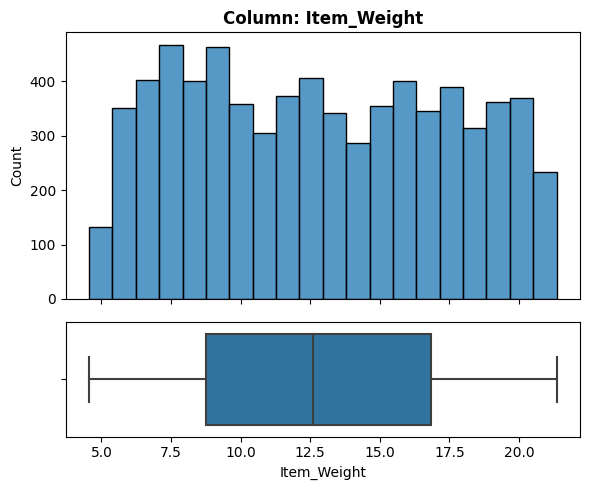

- NaN's Found: 1463 (17.17%)
- Unique Values: 415
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 1463 null values (17.17%)
  - impute with mean.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - No cardinale (numeric)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



- Excluding 1463 NaN's


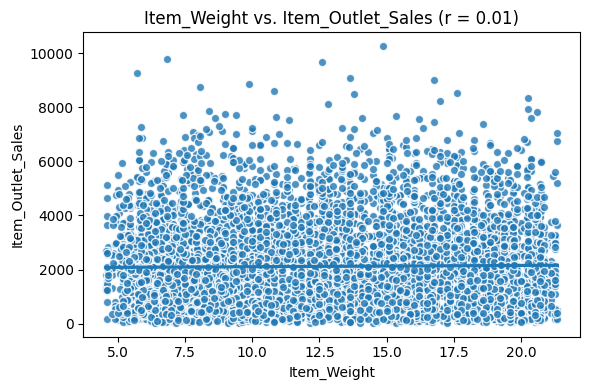

In [ ]:
plot_numeric_vs_target(df, feature,'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - No.

___

### Item_Fat_Content

In [ ]:
df['Item_Fat_Content'].value_counts(dropna=False)

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

- Item_Fat_Content: Whether the product is low-fat or regular.
  - Low Fat
  - Regular




In [ ]:
feature = "Item_Fat_Content"
df[feature].dtype

dtype('O')

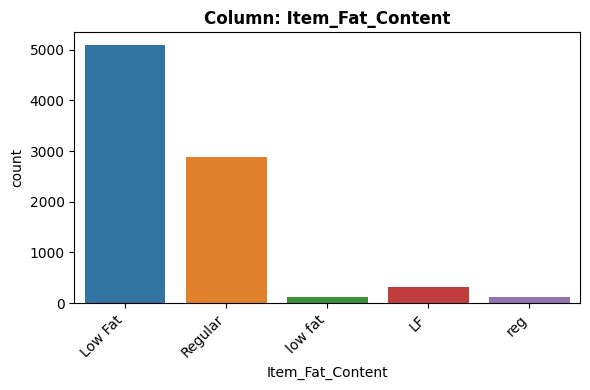

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'Low Fat' occurs 5089 times (59.71%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - ordinal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)
  - no need to impute.

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 2 unique categories.

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



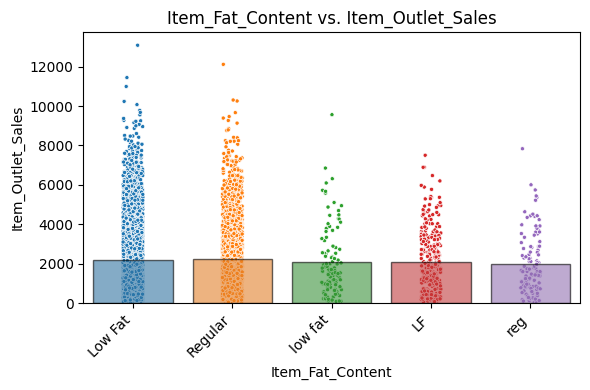

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes.
___

### Item_Visibility

- Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product


In [ ]:
feature = "Item_Visibility"
df[feature].dtype

dtype('float64')

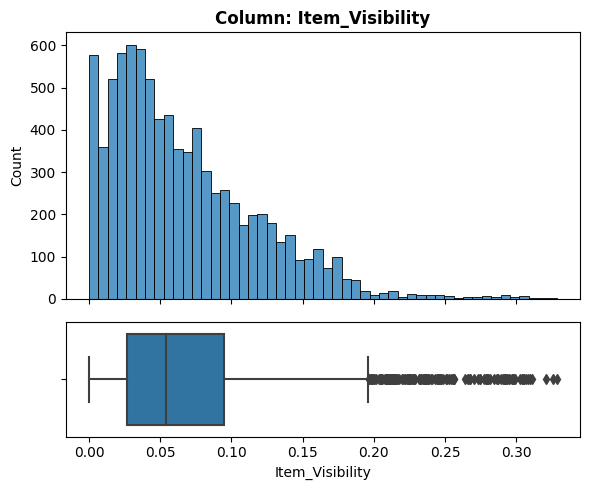

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - not cardinality (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Visibility vs. Item_Outlet_Sales (r = -0.13)'}, xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>)

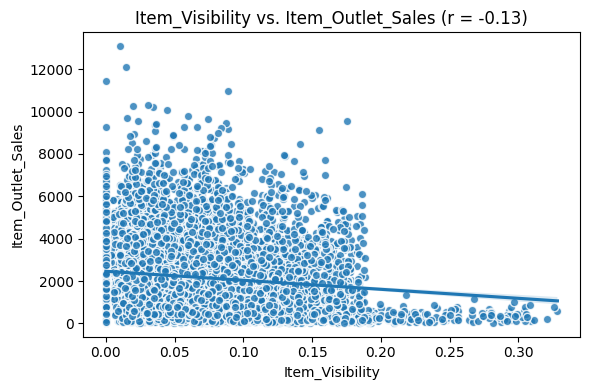

In [ ]:
plot_numeric_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes.

___

### Item_Type

- Item_Type: The category to which the product belongs.

In [ ]:
feature = "Item_Type"
df[feature].dtype

dtype('O')

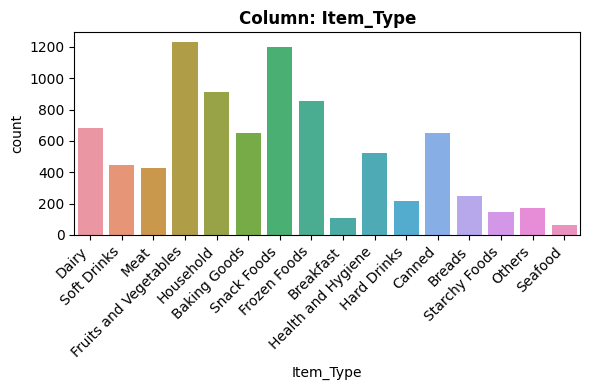

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 16 unique categories.
  - High cardinality (<10).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Item_Type vs. Item_Outlet_Sales'}, xlabel='Item_Type', ylabel='Item_Outlet_Sales'>)

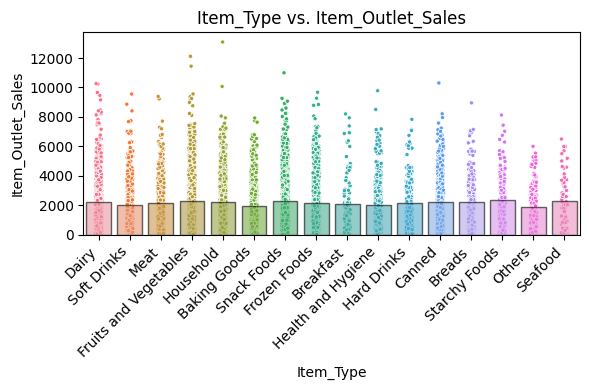

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - No .

___

### Item_MRP

- Item_MRP: Maximum Retail Price (list price) of the product

  

In [ ]:
feature = "Item_MRP"
df[feature].dtype

dtype('float64')

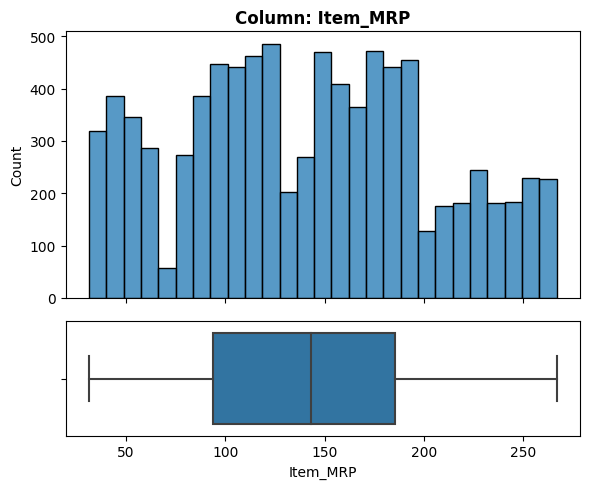

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - No cardinale (numeric)

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



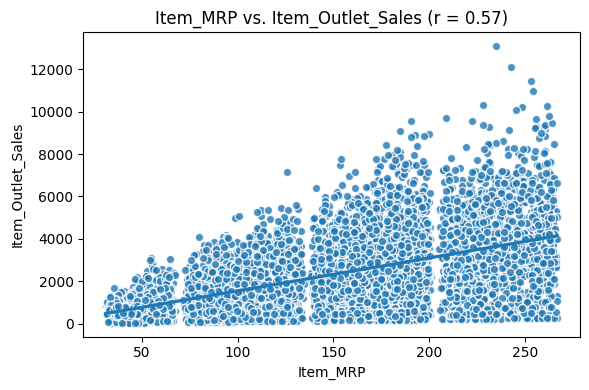

In [ ]:
plot_numeric_vs_target(df, feature,'Item_Outlet_Sales');

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes.

___

### Outlet_Identifier

- Outlet_Identifier: Store ID


In [ ]:
feature = "Outlet_Identifier"
df[feature].dtype

dtype('O')

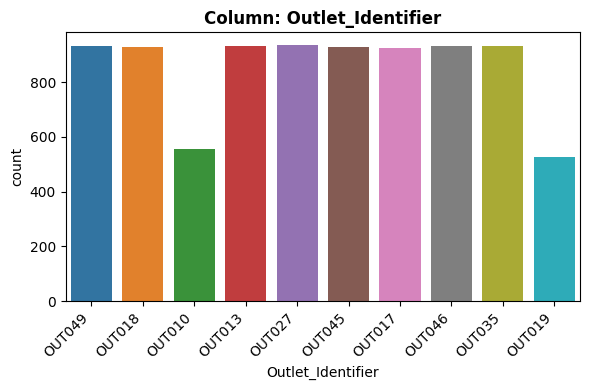

- NaN's Found: 0 (0.0%)
- Unique Values: 10
- Most common value: 'OUT027' occurs 935 times (10.97%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 10 unique values
  - High cardinality.

5. Would we know this BEFORE the target is determined?
  - No.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Identifier vs. Item_Outlet_Sales'}, xlabel='Outlet_Identifier', ylabel='Item_Outlet_Sales'>)

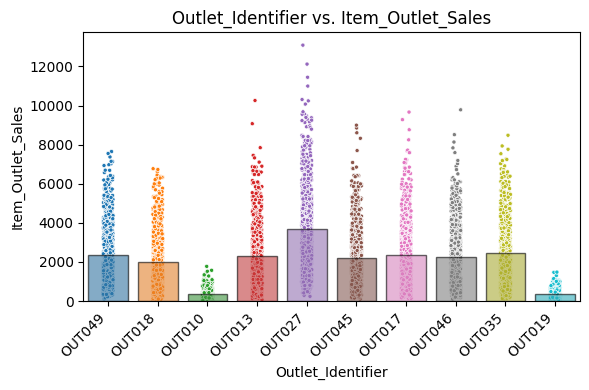

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes.

___

### Outlet_Establishment_Year

- Outlet_Establishment_Year: The year in which store was established

In [ ]:
feature = "Outlet_Establishment_Year"
df[feature].dtype

dtype('int64')

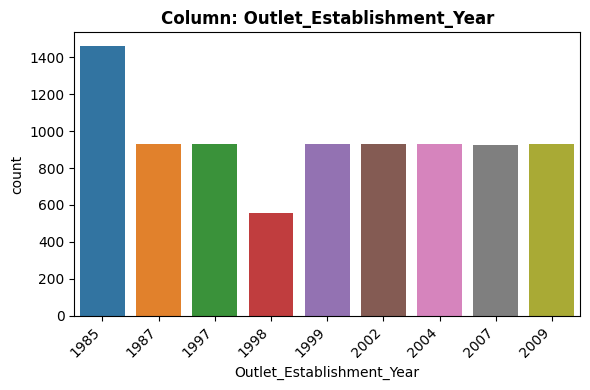

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: '1985' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - Categorical

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - Not high(8).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - Yes, they cann't change it.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Establishment_Year vs. Item_Outlet_Sales'}, xlabel='Outlet_Establishment_Year', ylabel='Item_Outlet_Sales'>)

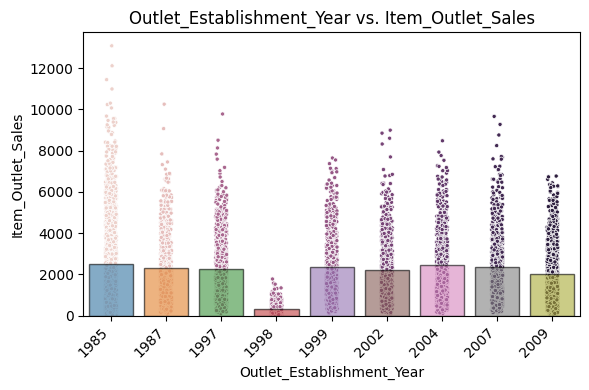

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes.

___

### Outlet_Size

In [ ]:
df['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

- Outlet_Size: The size of the store in terms of ground area covered
  - High
  - Medium
  - Small

In [ ]:
feature = "Outlet_Size"
df[feature].dtype

dtype('O')

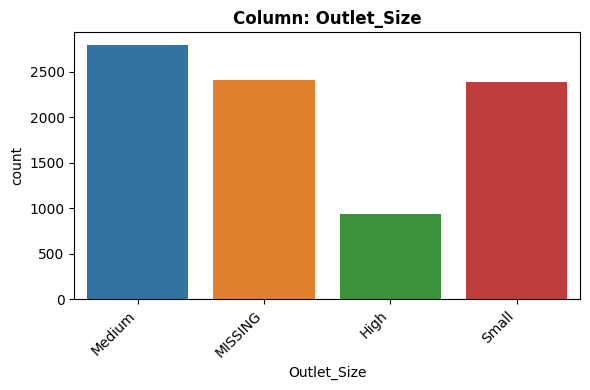

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - ordinal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 2410 null values (28.28%)
  - Impute NaN values with "NA"

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 4 unique categories.
  - Low cardinality (>10).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Size vs. Item_Outlet_Sales'}, xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>)

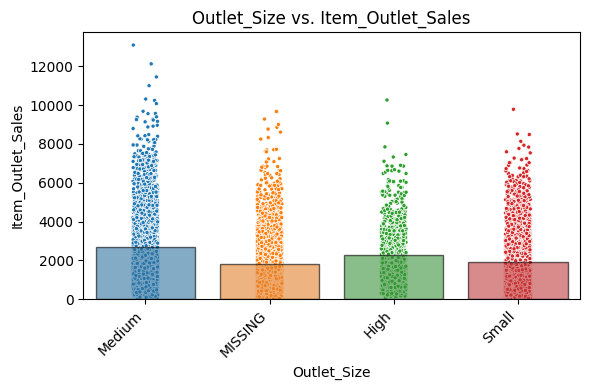

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes .

___

### Outlet_Location_Type

- Outlet_Location_Type: The type of area in which the store is located.
  - 1
  - 2
  - 3

In [ ]:
feature = "Outlet_Location_Type"
df[feature].dtype

dtype('O')

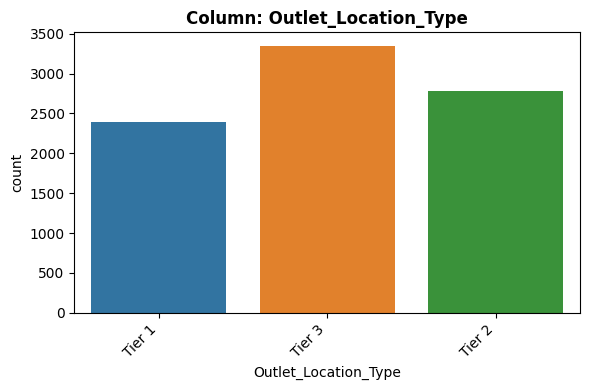

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 3 unique categories.
  - Low cardinality (>10).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Location_Type vs. Item_Outlet_Sales'}, xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>)

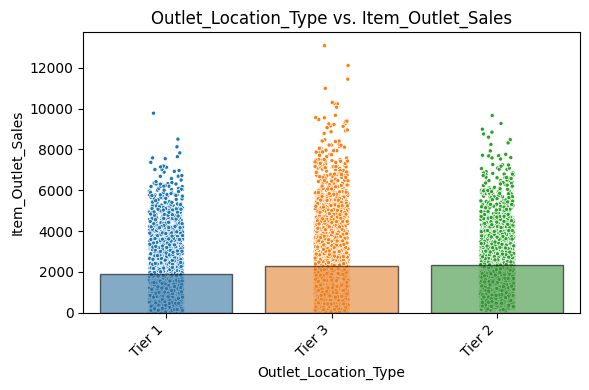

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes .

___

### Outlet_Type

In [ ]:
df['Outlet_Type'].value_counts(dropna=False)

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

- Outlet_Type: Whether the outlet is a grocery store or some sort of supermarket.
  - Supermarket Type1
  - Supermarket Type2
  - Supermarket Type3
  - Grocery Store

In [ ]:
feature = "Outlet_Type"
df[feature].dtype

dtype('O')

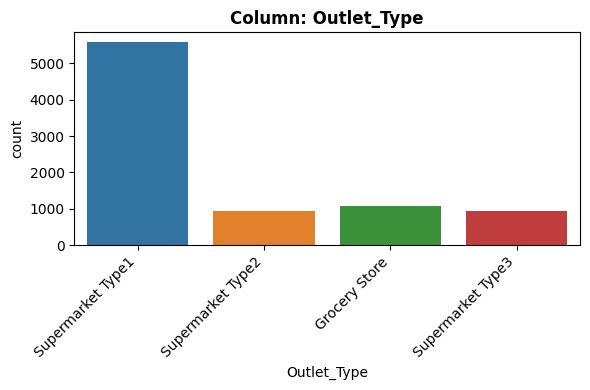

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - categorical (nominal)

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - No.

4. What is the cardinality? Is it high?
  - 4 unique categories.
  - Low cardinality (>10).

5. Would we know this BEFORE the target is determined?
  - Yes.

6. Is there a business case/understanding reason to exclude based on our business case?
  - No.



(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Outlet_Type vs. Item_Outlet_Sales'}, xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>)

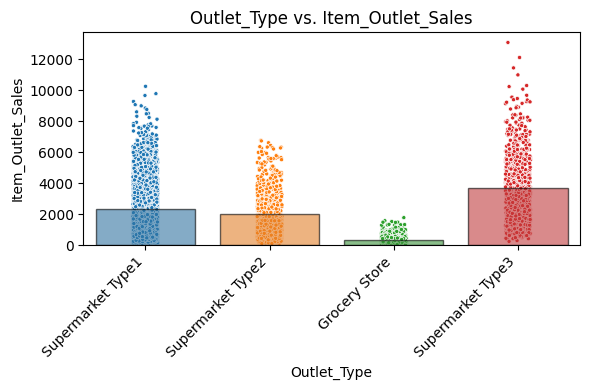

In [ ]:
plot_categorical_vs_target(df, feature,'Item_Outlet_Sales')

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - Yes.
  - Does this feature appear to be a predictor of the target?
    - Yes .

___

### Item_Outlet_Sales (target)

- rating: a rating of the cereals (Possibly from Consumer Reports?)

In [ ]:
feature = "Item_Outlet_Sales"
df[feature].dtype

dtype('float64')

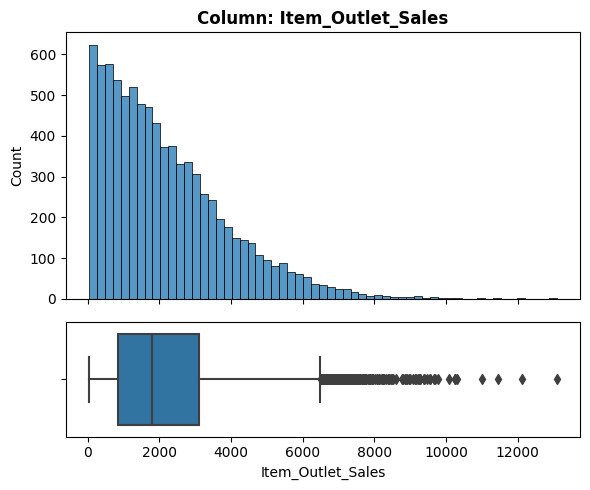

- NaN's Found: 0 (0.0%)
- Unique Values: 3493
- Most common value: '958.752' occurs 17 times (0.2%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df,feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0 null values (0.0%)

3. Is the feature constant or quasi-constant?
  - Not a feature.

4. What is the cardinality? Is it high?
  - not cardinality (numeric).

5. Would we know this BEFORE the target is determined?
  - Yes(target).

6. Is there a business case/understanding reason to exclude based on our business case?
  - Yes, its our target



#  Start to clean the data

In [ ]:
df.duplicated(keep=False).sum()

0

In [ ]:
df.isna().sum().sum()

3873

In [ ]:

print(df['Item_Fat_Content'].value_counts(dropna=False))
print(df['Outlet_Size'].value_counts(dropna=False))


Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64


In [ ]:
df = df.drop(columns=['Item_Identifier', 'Outlet_Establishment_Year','Outlet_Location_Type' ])

In [ ]:
# df['Outlet_Establishment_Year'].dtypes

In [ ]:
# df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype(object)

In [ ]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Supermarket Type1,994.7052


In [ ]:

# ord_features=['Item_Fat_Content', 'Outlet_Size']
# ord_orders=[['Low Fat', 'Regular'],['NA','Small', 'Medium', 'High']]

# col_transformer, X_train, y_train, X_test, y_test = preprocessor_maker(df,'Item_Outlet_Sales',ord_features = ord_features, ord_orders=ord_orders )

### drop 'Item_Identifier' from our data(no need).

In [ ]:
df['Item_Fat_Content'].value_counts(dropna=False, normalize=True)

Low Fat    0.597090
Regular    0.338965
LF         0.037076
reg        0.013728
low fat    0.013141
Name: Item_Fat_Content, dtype: float64

In [ ]:
fix_value = {
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fix_value)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# df['Item_Type'].value_counts(dropna=False).count()

In [ ]:
df['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [ ]:
(df['Outlet_Size'].isna() ).sum()

2410

In [ ]:
df[(df['Outlet_Size'].isna() )].head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Type,Item_Outlet_Sales
3,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Grocery Store,732.3800
8,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,NaN,Supermarket Type1,1076.5986
9,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,NaN,Supermarket Type1,4710.5350
25,13.000,Low Fat,0.099887,Household,45.9060,OUT017,NaN,Supermarket Type1,838.9080
28,5.925,Regular,0.161467,Dairy,45.5086,OUT010,NaN,Grocery Store,178.4344


In [ ]:
X = df.drop(columns = 'Item_Outlet_Sales')
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)



In [ ]:
# PREPROCESSING PIPELINE FOR NUMERIC DATA
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='mean')

scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
num_pipe



Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple



('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object'))

In [ ]:
# PREPROCESSING PIPELINE FOR ORDINAL DATA
# Save list of column names
ord_cols = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)
# Create imputer for ordinal data
impute_na_ord = SimpleImputer(strategy='constant', fill_value='NA')
## Making the OrdinalEncoder
# Specifying order of categories for our  Ordinal Qual/Cond Columms
qual_cond_order = ['NA', 'Small','Medium', 'High']
# Making the list of order lists for OrdinalEncoder
ordinal_category_orders = [qual_cond_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
# Making a final scaler to scale category #'s
scaler_ord = StandardScaler()
## Making an ord_pipe
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)
ord_pipe


Ordinal Columns: ['Outlet_Size']


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['NA', 'Small', 'Medium',
                                             'High']])),
                ('standardscaler', StandardScaler())])

In [ ]:
# Making an ordinal_tuple for ColumnTransformer
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple



('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['NA', 'Small', 'Medium',
                                              'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

In [ ]:
# PREPROCESSING PIPELINE FOR ONE-HOT-ENCODED DATA
# Save list of column names
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
ohe_pipe



OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object')


Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple



('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))

In [ ]:
# Instantiate with verbose_feature_names_out=False
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'Sma...
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# Fit on training data
col_transformer.fit(X_train)
# X_train.columns

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'Sma...
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

In [ ]:
# Transform the training data
X_train_processed = col_transformer.transform(X_train)
# Transform the testing data
X_test_processed = col_transformer.transform(X_test)
# View the processed training data
X_train_processed.info()
X_train_processed.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Item_Weight                      6392 non-null   float64
 1   Item_Visibility                  6392 non-null   float64
 2   Item_MRP                         6392 non-null   float64
 3   Outlet_Size                      6392 non-null   float64
 4   Item_Fat_Content_Low Fat         6392 non-null   float64
 5   Item_Fat_Content_Regular         6392 non-null   float64
 6   Item_Type_Baking Goods           6392 non-null   float64
 7   Item_Type_Breads                 6392 non-null   float64
 8   Item_Type_Breakfast              6392 non-null   float64
 9   Item_Type_Canned                 6392 non-null   float64
 10  Item_Type_Dairy                  6392 non-null   float64
 11  Item_Type_Frozen Foods           6392 non-null   float64
 12  Item_Type_Fruits 

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.817249,-0.712775,1.828109,0.748125,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7510,0.556340,-1.291052,0.603369,0.748125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5828,-0.131512,1.813319,0.244541,0.748125,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5327,-1.169219,-1.004931,-0.952591,-0.264370,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4810,1.528819,-0.965484,-0.336460,-1.276865,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# Project 1 - Part 6 (Core)



---



---



---



---



## build a linear regression model to predict sales

In [ ]:
linreg = LinearRegression()
model_selected_pip = make_pipeline(col_transformer, linreg)
model_selected_pip.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('ordinalencoder',...
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
evaluate_regression(model_selected_pip, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.129
- MSE = 1,297,558.136
- RMSE = 1,139.104
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.120
- MSE = 1,194,349.715
- RMSE = 1,092.863
- R^2 = 0.567


### is this model overfit/underfit?
  - underfit.



---



---



---



---



## build a Random Forest model to predict sales

In [ ]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)

rf_pipe.fit(X_train, y_train)

evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.800
- MSE = 183,083.082
- RMSE = 427.882
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 769.514
- MSE = 1,223,984.977
- RMSE = 1,106.339
- R^2 = 0.556


### is this model overfit/underfit?
  - overfit.

### Compare this model's performance to the linear regression model: which model has the best test scores?
  - random forest have low MAE for both test and train data



---



---



---



## Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.



In [ ]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)
# Define param grid with options to try
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

# Instantiate the gridsearch
# gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)
gridsearch = RandomizedSearchCV(rf_pipe, params, n_jobs=-1, cv = 10, verbose=1)


# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)
evaluate_regression(gridsearch, X_train, y_train, X_test, y_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 655.926
- MSE = 874,680.989
- RMSE = 935.244
- R^2 = 0.704

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 736.649
- MSE = 1,120,618.323
- RMSE = 1,058.593
- R^2 = 0.594


### Compare your tuned model to your default Random Forest: did the performance improve?
  - Yes, the R^2 increase for test data and the MSE decrease after the tuning


---



---



---



## You now have tried several different models on your data set. You need to determine which model to implement.



### Overall, which model do you recommend?
   - Random Forest model with tuning

### Justify your recommendation.
**Interpreting Model Performance for Non-Technical Stakeholders:**

1. **R-squared (R²):**
   - R² is a measure of how well the model fits the data. It ranges from 0 to 1, where a higher value indicates a better fit.
   - In this case, the R² values for the test data are around 0.56 for both the Linear Regression and Random Forest models. This means that our models explain approximately 56% of the variance in the target variable (PRICE) on unseen data.

2. **Mean Absolute Error (MAE):**
   - MAE represents the average absolute error between the predicted and actual values.
   - For the Linear Regression model, the MAE on the test data is approximately 804.16. This means that, on average, the model's predictions have an error of 804.16 when predicting the prices of houses.
   - For the Random Forest model, the MAE on the test data is approximately 766.66, indicating an average prediction error of 766.66.

**Why MAE?**
I selected MAE as the metric to explain to stakeholders because it provides an intuitive understanding of prediction errors in terms of the currency (dollars in this case). This is easier for non-technical stakeholders to grasp since they can relate to monetary values. Lower MAE values indicate better model performance in terms of minimizing prediction errors.

**Model Fit:**
Comparing the training and test scores, we can see that the R² values for both models are similar between training and test data (around 0.56), suggesting that the models generalize reasonably well to unseen data. There is no significant overfitting or underfitting in these models.

In summary, the models perform reasonably well in explaining the variation in house prices. The average prediction error in dollars (MAE) is around $800 to 766.66. These models are fairly consistent between training and test datasets, indicating good generalization and robust performance.

# Part 8

## LinearRegression

In [ ]:
linreg.fit(X_train_processed, y_train)

LinearRegression()

In [ ]:
# Obtain coefficients from linear regression model
linreg.coef_

array([   -8.18675225,   -21.64647339,   984.51307395,   173.60689262,
         -31.3126168 ,    31.3126168 ,   -18.61254054,   -47.26085866,
          26.74852315,     8.9036537 ,  -124.9475549 ,   -20.38316674,
          27.14148896,    -4.71764142,     8.41287319,   -13.10279417,
         -30.47742718,   -45.42626629,   308.88859562,   -40.54493311,
         -58.09827577,    23.47632414,  -430.68983765,  -253.35028501,
         281.89092329,   -65.13251396,  -575.36550383,   788.86716976,
         157.22984647,   140.34252377,    10.23367209,   -54.02599493,
       -1006.05534147,   282.32068568,   -65.13251396,   788.86716976])

In [ ]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,NaN,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,High,Supermarket Type1,994.7052


In [ ]:

# Saving the coefficients as Pandas series
coeffs = pd.Series(linreg.coef_, index= linreg.feature_names_in_)
coeffs

# use .loc to add the intercept to the series
coeffs.loc['intercept'] = linreg.intercept_
coeffs

pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs




Item_Weight                           -8.19
Item_Visibility                      -21.65
Item_MRP                             984.51
Outlet_Size                          173.61
Item_Fat_Content_Low Fat             -31.31
Item_Fat_Content_Regular              31.31
Item_Type_Baking Goods               -18.61
Item_Type_Breads                     -47.26
Item_Type_Breakfast                   26.75
Item_Type_Canned                       8.90
Item_Type_Dairy                     -124.95
Item_Type_Frozen Foods               -20.38
Item_Type_Fruits and Vegetables       27.14
Item_Type_Hard Drinks                 -4.72
Item_Type_Health and Hygiene           8.41
Item_Type_Household                  -13.10
Item_Type_Meat                       -30.48
Item_Type_Others                     -45.43
Item_Type_Seafood                    308.89
Item_Type_Snack Foods                -40.54
Item_Type_Soft Drinks                -58.10
Item_Type_Starchy Foods               23.48
Outlet_Identifier_OUT010        

In [ ]:
X = df.drop(columns = 'Item_Outlet_Sales')
y = df['Item_Outlet_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

num_cols = X_train.select_dtypes("number").columns

impute_median = SimpleImputer(strategy='mean')

scaler = StandardScaler()

num_pipe = make_pipeline(impute_median, scaler)


ord_cols = ['Outlet_Size']

impute_na_ord = SimpleImputer(strategy='constant', fill_value='NA')

qual_cond_order = ['NA', 'Small','Medium', 'High']

ordinal_category_orders = [qual_cond_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

scaler_ord = StandardScaler()

ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)



ord_tuple = ('ordinal', ord_pipe, ord_cols)


ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns

impute_na = SimpleImputer(strategy='constant', fill_value = "NA")

ohe_encoder = OneHotEncoder(drop = 'first', sparse=False)

ohe_pipe = make_pipeline(impute_na, ohe_encoder)


ohe_tuple = ('categorical', ohe_pipe, ohe_cols)


col_transformer_dropfirst = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],verbose_feature_names_out=False)


In [ ]:
col_transformer_dropfirst.fit(X_train)

X_train_processed_dropfirst = col_transformer_dropfirst.transform(X_train)

X_test_processed_dropfirst = col_transformer_dropfirst.transform(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
linreg.fit(X_train_processed_dropfirst, y_train)

LinearRegression()

In [ ]:

# Saving the coefficients as Pandas series
coeffs = pd.Series(linreg.coef_, index= linreg.feature_names_in_, name='liniar parameter')


# use .loc to add the intercept to the series
coeffs.loc['intercept'] = linreg.intercept_

pd.set_option('display.float_format', lambda x: f"{x:,.2f}")
coeffs



Item_Weight                          -8.19
Item_Visibility                     -21.65
Item_MRP                            984.51
Outlet_Size                         508.65
Item_Fat_Content_Regular             62.63
Item_Type_Breads                    -28.65
Item_Type_Breakfast                  45.36
Item_Type_Canned                     27.52
Item_Type_Dairy                    -106.34
Item_Type_Frozen Foods               -1.77
Item_Type_Fruits and Vegetables      45.75
Item_Type_Hard Drinks                13.89
Item_Type_Health and Hygiene         27.03
Item_Type_Household                   5.51
Item_Type_Meat                      -11.86
Item_Type_Others                    -26.81
Item_Type_Seafood                   327.50
Item_Type_Snack Foods               -21.93
Item_Type_Soft Drinks               -39.49
Item_Type_Starchy Foods              42.09
Outlet_Identifier_OUT013           -726.56
Outlet_Identifier_OUT017            826.37
Outlet_Identifier_OUT018            314.01
Outlet_Iden

In [ ]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict




def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6),
                          color_dict=None, ax=None):

    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)

    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)

    ## return ax in case want to continue to update/modify figure
    return ax

<Axes: title={'center': 'Top 7 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

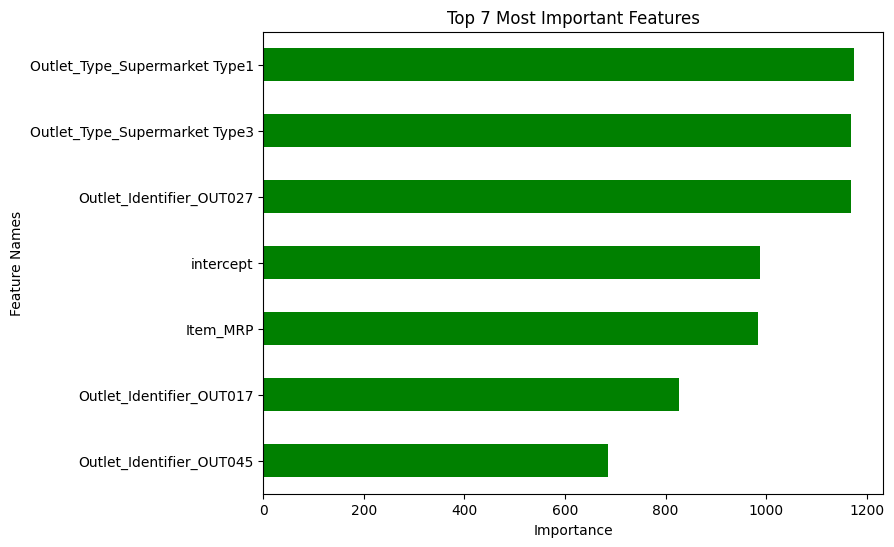

In [ ]:
colors_top7 = get_color_dict(coeffs, top_n=7)


fig, axes = plt.subplots(ncols=1, figsize=(20,8))
n = 7 # setting the # of features to use for both subplots
plot_importance_color_ax(coeffs, top_n=n,
                         color_dict= colors_top7)


## Tree-Based Model


In [ ]:
rf.fit(X_train_processed_dropfirst, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
rf.feature_importances_

array([0.05691575, 0.10145283, 0.44533126, 0.03832322, 0.00914389,
       0.00257432, 0.0026242 , 0.00433346, 0.00624774, 0.00608069,
       0.008108  , 0.00307266, 0.00418036, 0.00679094, 0.00378611,
       0.00165698, 0.00186855, 0.00853168, 0.00543672, 0.00351289,
       0.00340919, 0.00498185, 0.0195458 , 0.00169723, 0.05112448,
       0.00688332, 0.00522289, 0.00707113, 0.00491428, 0.09295423,
       0.02175912, 0.06046423])

In [ ]:
col_transformer_dropfirst.fit(X_train)
feature_names = col_transformer_dropfirst.get_feature_names_out()




/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Saving the feature importances
importances = pd.Series(rf.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances



Item_Weight                       0.06
Item_Visibility                   0.10
Item_MRP                          0.45
Outlet_Size                       0.04
Item_Fat_Content_Regular          0.01
Item_Type_Breads                  0.00
Item_Type_Breakfast               0.00
Item_Type_Canned                  0.00
Item_Type_Dairy                   0.01
Item_Type_Frozen Foods            0.01
Item_Type_Fruits and Vegetables   0.01
Item_Type_Hard Drinks             0.00
Item_Type_Health and Hygiene      0.00
Item_Type_Household               0.01
Item_Type_Meat                    0.00
Item_Type_Others                  0.00
Item_Type_Seafood                 0.00
Item_Type_Snack Foods             0.01
Item_Type_Soft Drinks             0.01
Item_Type_Starchy Foods           0.00
Outlet_Identifier_OUT013          0.00
Outlet_Identifier_OUT017          0.00
Outlet_Identifier_OUT018          0.02
Outlet_Identifier_OUT019          0.00
Outlet_Identifier_OUT027          0.05
Outlet_Identifier_OUT035 

<Axes: title={'center': 'Top 7 Most Important Features'}, xlabel='Importance', ylabel='Feature Names'>

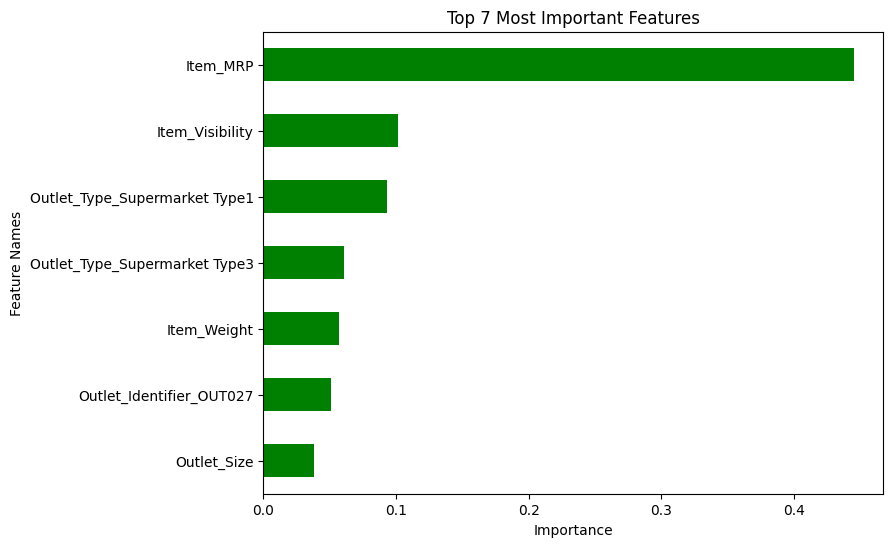

In [ ]:
colors_top7 = get_color_dict(importances, top_n=7)


fig, axes = plt.subplots(ncols=1, figsize=(20,8))
n = 7 # setting the # of features to use for both subplots
plot_importance_color_ax(importances, top_n=n,
                         color_dict= colors_top7)
